In [63]:
import requests
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

from utils.subgraph_utils.constants import SUBGRAPH_API

In [20]:
scope = "daily"

In [18]:
pool_addresses = {}
for network_name, api in SUBGRAPH_API.items():
    query = """
    {
      platforms {
        poolAddresses
      }
    }
    """
    r = requests.post(api, json={'query': query})
    data = dict(r.json())
    pool_addresses[network_name] = data['data']['platforms'][0]['poolAddresses']
pool_addresses

{'Mainnet': ['0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7',
  '0x8038c01a0390a8c547446a0b2c18fc9aefecc10c',
  '0x7fc77b5c7614e1533320ea6ddc2eb61fa00a9714',
  '0x071c661b4deefb59e2a3ddb20db036821eee8f4b',
  '0xd81da8d904b52208541bade1bd6595d8a251f8dd',
  '0x7f55dde206dbad629c080068923b36fe9d6bdbef',
  '0x890f4e345b1daed0367a877a1612f86a1f86985f',
  '0x0ce6a5ff5217e38315f87032cf90686c96627caa',
  '0xc5424b857f758e906013f3555dad202e4bdb4567',
  '0xdebf20617708857ebe4f679508e7b7863a8a8eee',
  '0x83f252f036761a1e3d10daca8e16d7b21e3744d7',
  '0xdc24316b9ae028f1497c275eb9192a3ea0f67022',
  '0xa96a65c051bf88b4095ee1f2451c2a9d43f53ae2',
  '0xeb16ae0052ed37f479f7fe63849198df1765a733',
  '0x8925d9d9b4569d737a48499def3f67baa5a144b9',
  '0x2dded6da1bf5dbdf597c45fcfaa3194e53ecfeaf',
  '0xf178c0b5bb7e7abf4e12a4838c7b7c5ba2c623c0',
  '0x36965b1a6b97c1b33416e5d53fb5621ade1f1e80',
  '0x42d7025938bec20b69cbae5a77421082407f053a',
  '0xecd5e75afb02efa118af914515d6521aabd189f1',
  '0x52eeea483ab7a801e2592a90

In [50]:
entity = scope + "SwapVolumeSnapshots"
volume_data = {}
for network_name in pool_addresses.keys():

    network_volume_data = pd.DataFrame()

    for pool_address in pool_addresses[network_name]:
        query = f"""
        {{
          {entity}(
            first: 1000,
            orderBy: timestamp,
            orderDirection: desc,
            where: {{
                pool: "{pool_address}"
            }}
          )
          {{
            timestamp
            volumeUSD
        }}
        }}
        """
        r = requests.post(SUBGRAPH_API[network_name], json={'query': query})
        data = dict(r.json())
        timestamps = [int(i['timestamp']) for i in data['data'][entity]]
        timestamps = [datetime.datetime.fromtimestamp(i) for i in timestamps]

        data = pd.DataFrame(data['data'][entity])
        if data.empty:
            continue

        data["volumeUSD"] = data.volumeUSD.astype(float)
        timestamps = [datetime.datetime.fromtimestamp(int(i)) for i in data.timestamp]
        data['timestamp'] = timestamps
        data.set_index('timestamp', inplace=True)
        data.sort_index(ascending=True, inplace=True)
        data.fillna(0, inplace=True)

        network_volume_data[pool_address] = data.volumeUSD

    network_volume_data.fillna(0, inplace=True)
    volume_data[network_name] = network_volume_data

volume_data

{'Mainnet':                      0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7  \
 timestamp                                                         
 2020-11-08 00:00:00                                1.112663e+06   
 2020-11-09 00:00:00                                2.305998e+07   
 2020-11-10 00:00:00                                8.329988e+06   
 2020-11-11 00:00:00                                7.939894e+06   
 2020-11-12 00:00:00                                1.637585e+07   
 ...                                                         ...   
 2022-05-08 01:00:00                                1.481758e+07   
 2022-05-09 01:00:00                                1.401704e+08   
 2022-05-10 01:00:00                                4.356445e+07   
 2022-05-11 01:00:00                                1.017654e+09   
 2022-05-12 01:00:00                                1.961384e+09   
 
                      0x8038c01a0390a8c547446a0b2c18fc9aefecc10c  \
 timestamp                         

In [56]:
df_volume = pd.DataFrame()
for network_name in volume_data.keys():
    df_volume[network_name] = volume_data[network_name].sum(axis=1)

df_volume.fillna(0, inplace=True)
df_volume

,Mainnet,xDAI,Arbitrum,Fantom,Avalanche,Matic,Optimism
timestamp,,,,,,,
2020-11-08 00:00:00,1.124739e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-11-09 00:00:00,2.383208e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-11-10 00:00:00,8.515651e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-11-11 00:00:00,8.139687e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-11-12 00:00:00,1.653018e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
2022-05-08 01:00:00,2.041749e+09,2.432997e+05,7.631711e+06,5.414620e+07,6.600545e+07,1.104993e+07,1.898318e+06
2022-05-09 01:00:00,2.983307e+09,3.085237e+05,2.175792e+07,9.504993e+07,1.514454e+08,8.625232e+08,6.391372e+06
2022-05-10 01:00:00,2.490718e+09,3.686382e+05,1.729548e+07,1.294422e+08,1.810621e+08,5.513035e+07,4.935005e+06


Plotting

In [57]:
df_volume_monthly = df_volume.groupby(pd.Grouper(freq='1M')).sum()
df_volume_monthly

,Mainnet,xDAI,Arbitrum,Fantom,Avalanche,Matic,Optimism
timestamp,,,,,,,
2020-11-30,7.323446e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-12-31,9.279376e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-31,3.321550e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-02-28,3.313695e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-03-31,3.980075e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-04-30,8.235347e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-05-31,8.624800e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-06-30,1.503824e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-07-31,5.943623e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.548416e+06,0.000000e+00


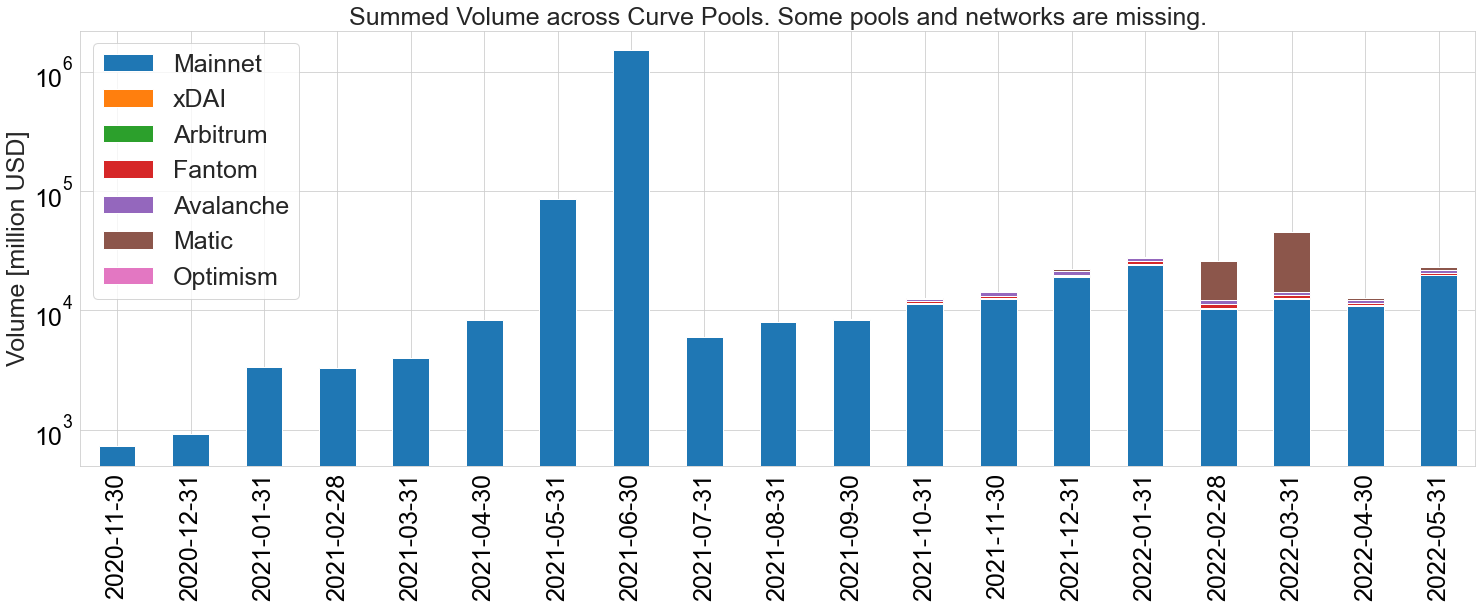

In [85]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

(df_volume_monthly * 1e-6).plot.bar(ax=ax, stacked=True)

ax.set_yscale('log')
ax.set_ylabel("Volume [million USD]", fontsize=25)
ax.set_xlabel("", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')

ax.set_title(f"Summed Volume across Curve Pools. Some pools and networks are missing.", fontsize=25)

ax.legend(fontsize=25);

In [83]:
df_volume_monthly

,Mainnet,xDAI,Arbitrum,Fantom,Avalanche,Matic,Optimism
2020-11-30,7.323446e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-12-31,9.279376e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-31,3.321550e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-02-28,3.313695e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-03-31,3.980075e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-04-30,8.235347e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-05-31,8.624800e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-06-30,1.503824e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-07-31,5.943623e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.548416e+06,0.000000e+00
2021-08-31,7.918236e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.659178e+07,0.000000e+00
